# Testing Filters

In [1]:
import scipy.io as sio
from scipy import signal
from sklearn.preprocessing import StandardScaler 
import pandas as pd
import numpy as np
import iisignature

import matplotlib as mpl 
import matplotlib.pyplot as plt

In [2]:
mpl.rc('axes.spines', top=True, bottom=True, left=True, right=True)
#mpl.rc('axes', facecolor='white')
mpl.rc("xtick", bottom=True, labelbottom=True)
mpl.rc("ytick", left=True, labelleft=True)
mpl.style.use('ggplot')

# center images
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage, .output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
test_data_path = 'signatures_data/db5/s1/S1_E1_A1.mat'

mat = sio.loadmat(test_data_path)

In [17]:
data_emg = pd.DataFrame(mat['emg'])
data_emg['stimulus'] = mat['restimulus']
data_emg['repetition'] = mat['repetition']

<AxesSubplot: title={'center': 'sEMG Electrode Signals'}>

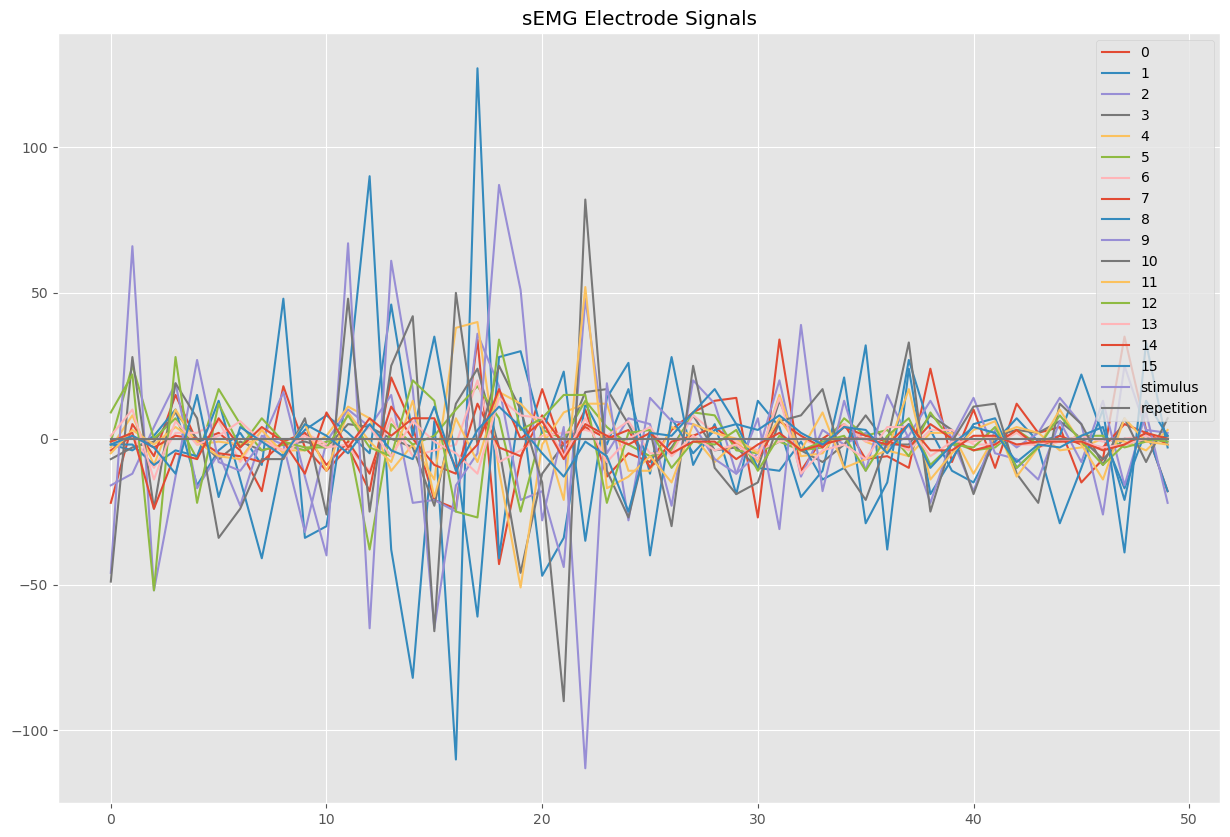

In [18]:
data_emg[:50].plot(figsize=(15,10), title="sEMG Electrode Signals")

In [19]:
# taken from section 3.3.1 of https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0186132 
train_set = [1, 3, 5, 6]
validation_set = [2, 5]

In [20]:
# the last column specifies the repetition number
np.unique(data_emg.values[:, 17])

array([0., 1., 2., 3., 4., 5., 6.], dtype=float32)

In [21]:
# TODO: DB5 specific right now, change so extracts by last column in general 
def normalize(data : pd.DataFrame, train_reps : list) -> pd.DataFrame:
    """
    Given sEMG data and exercise repetitions, extracts the subset of data corresponding by specification,
    which is centered and scaled to unit variance. 
    
    Parameters
    ----------
    data : pd.Dataframe 
        Collection of sensor data from which repetitions are to be extracted 
    train_reps : list 
        Specified exercise repetitions to extract by 
        
    Returns 
    -------
    pd.DataFrame
        Centered and unit-variance scaled sensor data for specified exercise repetitions

    """
    x = [np.where(data.values[:,17] == rep) for rep in train_reps]
    indices = np.squeeze(np.concatenate(x, axis = -1))
    train_data = data.iloc[indices, :].reset_index(drop=True)
    
    scaler = StandardScaler(with_mean=True,
                                with_std=True,
                                copy=False).fit(train_data.iloc[:, :16])
    
    scaled = scaler.transform(data.iloc[:,:16])
    normalized = pd.DataFrame(scaled)
    normalized['stimulus'], normalized['repetition'] = data['stimulus'], data['repetition']

    return normalized

<AxesSubplot: title={'center': 'Normalized sEMG Electrode Signals'}>

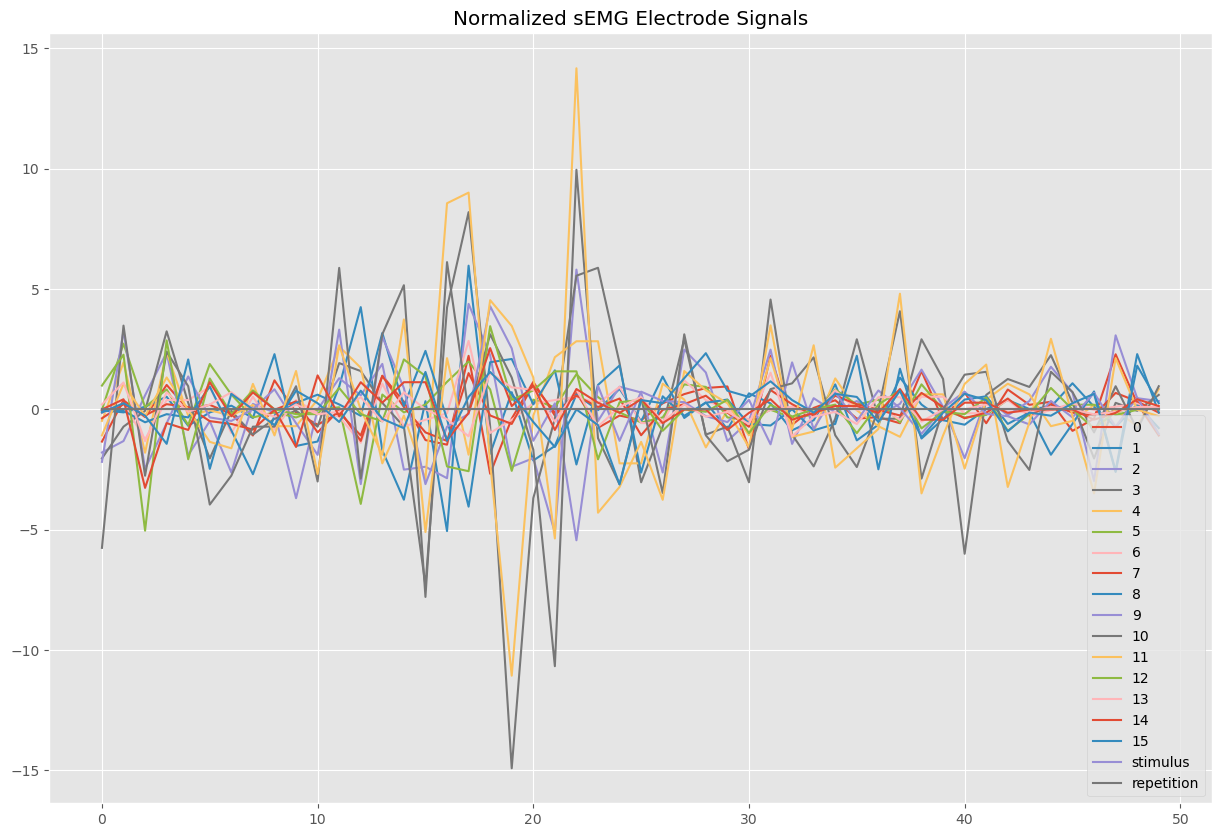

In [22]:
normalized_emg = normalize(data_emg, train_set)
normalized_emg[:50].plot(figsize=(15,10), title="Normalized sEMG Electrode Signals")

In [23]:
def frequency_filter(data : pd.DataFrame, f, order, btype, sample_rate): 
    """
    Butterworth frequency filter. Given data, type of filter, order, and sample rate, 
    applies the corresponding Butterworth frequency filter. 
    
    Parameters
    ----------
    
    Returns
    -------
    
    """
    nyquist_f = sample_rate / 2 
    
    fc = f / nyquist_f if isinstance(f, int) else [f_i / nyquist_f for f_i in f]
    
    b, a = signal.butter(order, fc, btype=btype)
    
    data_copy_T = data.T.copy() 
    
    for i in range(len(data_copy_T)):
        data_copy_T[i] = signal.lfilter(b, a, data_copy_T[i])
        
    return pd.DataFrame(data_copy_T.T)

In [24]:
emg_lowpass = frequency_filter(normalized_emg.values[:, :16], 20, 4, 'lowpass', 2000)
emg_bandpass = frequency_filter(normalized_emg.values[:, :16], (20, 40), 4, 'bandpass', 2000)
emg_highpass = frequency_filter(normalized_emg.values[:, :16], 20, 4, 'highpass', 2000)
emg_bandstop = frequency_filter(normalized_emg.values[:, :16], (20, 40), 4, 'bandstop', 2000)

<AxesSubplot: title={'center': 'sEMG Data Filtered with Lowpass Butterworth'}>

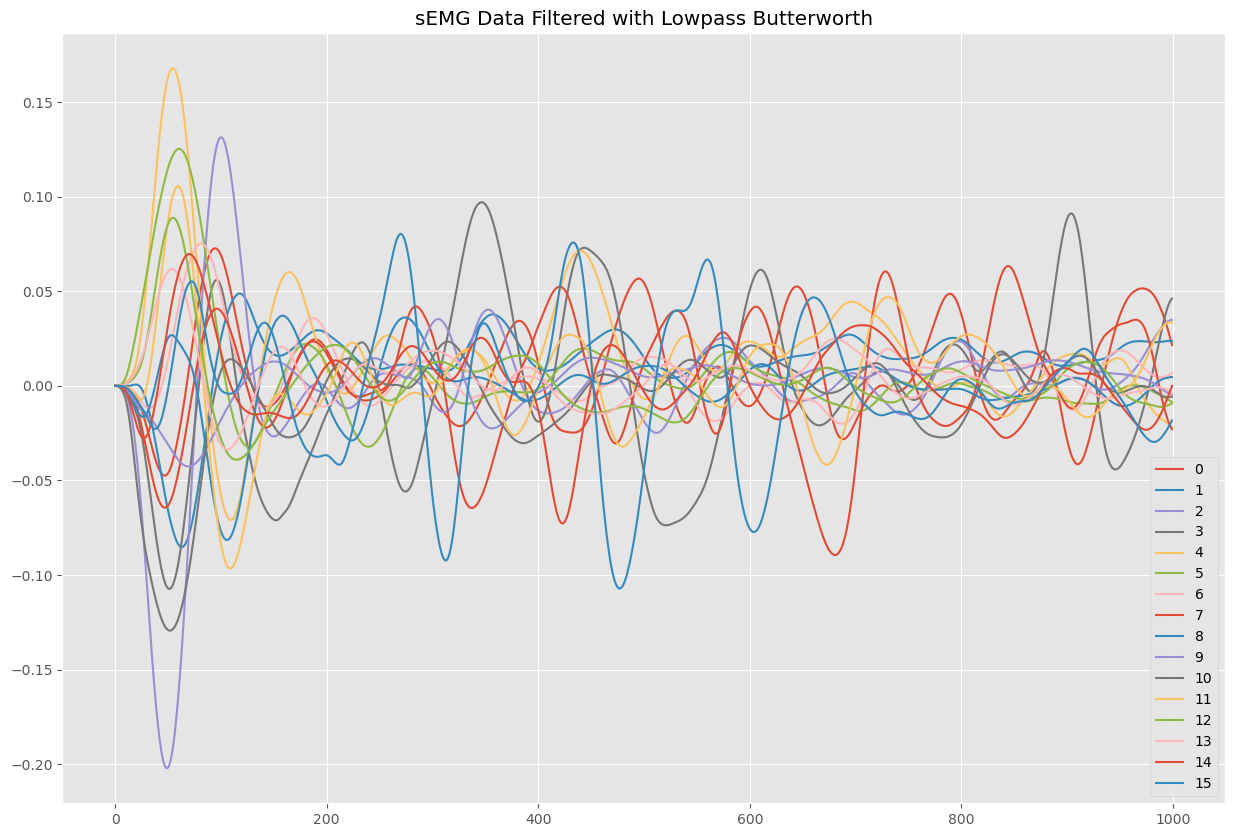

In [25]:
emg_lowpass[:1000].plot(figsize=(15,10), title='sEMG Data Filtered with Lowpass Butterworth')

<AxesSubplot: title={'center': 'sEMG Data Filtered with Bandpass Butterworth'}>

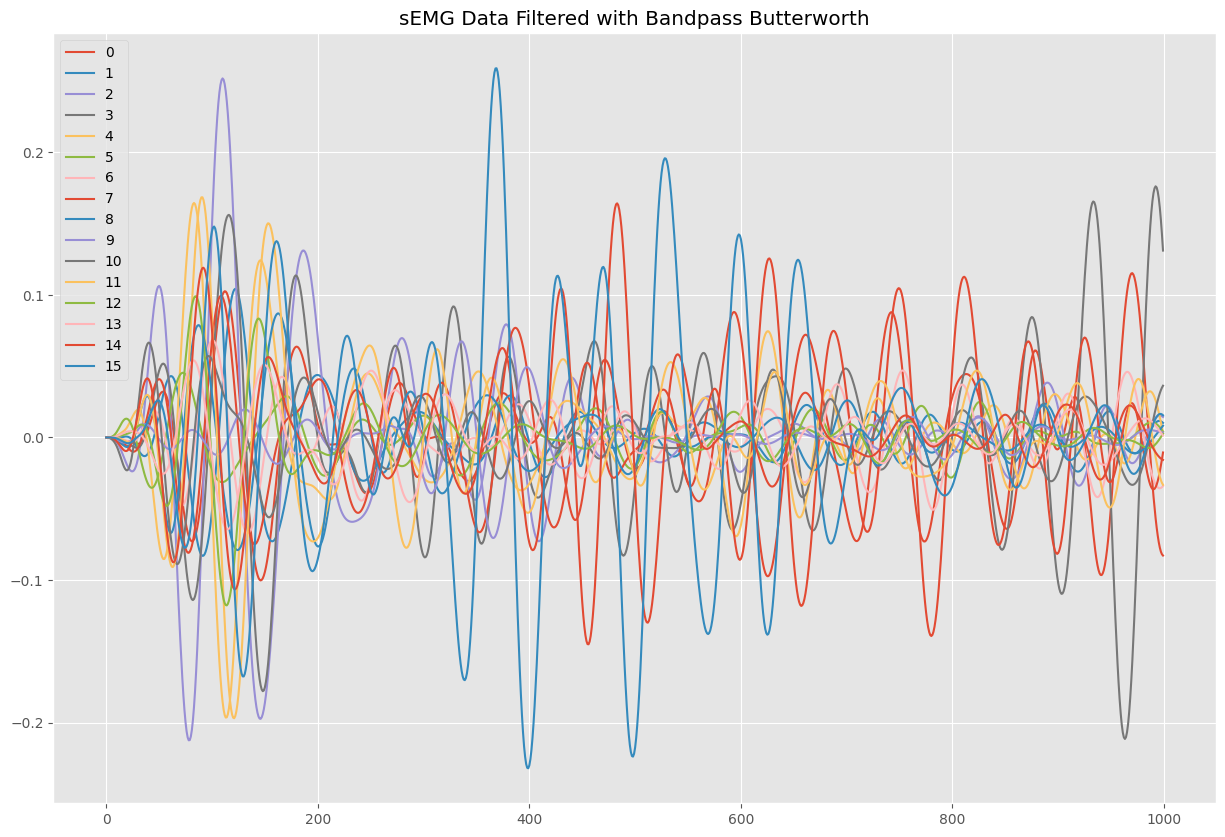

In [59]:
emg_bandpass[:1000].plot(figsize=(15,10), title='sEMG Data Filtered with Bandpass Butterworth')

<AxesSubplot: title={'center': 'sEMG Data Filtered with Highpass Butterworth'}>

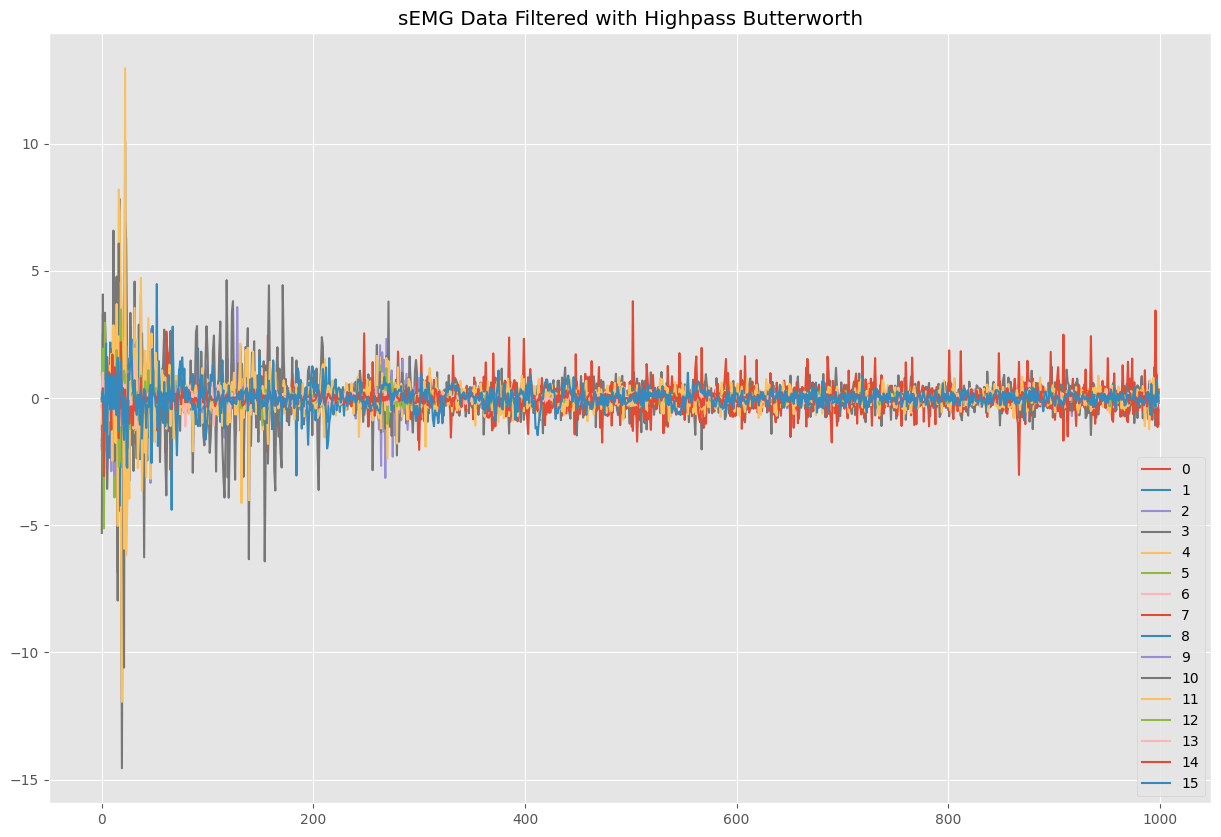

In [60]:
emg_highpass[:1000].plot(figsize=(15,10), title='sEMG Data Filtered with Highpass Butterworth')

<AxesSubplot: title={'center': 'sEMG Data Filtered with Bandstop Butterworth'}>

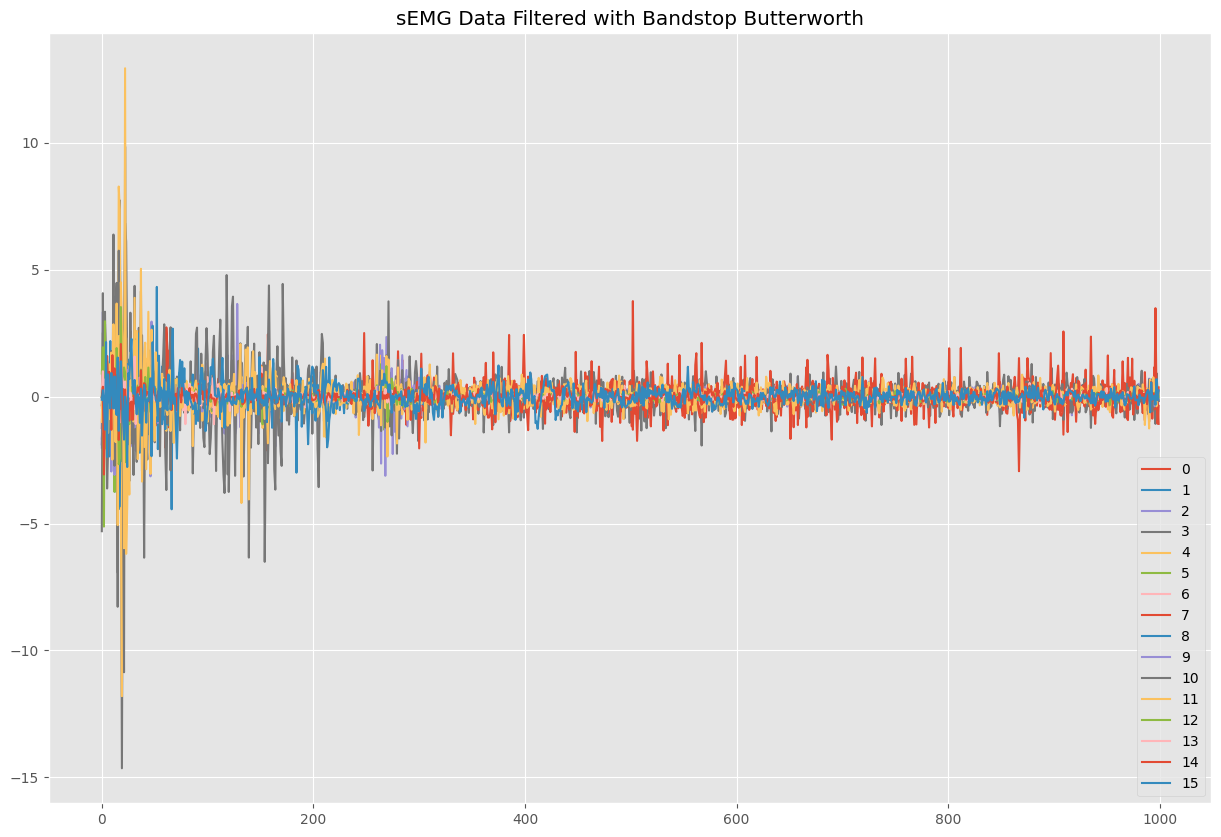

In [61]:
emg_bandstop[:1000].plot(figsize=(15,10), title='sEMG Data Filtered with Bandstop Butterworth')

In [34]:
np.unique(normalized_emg.stimulus) # different gestures 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int8)

In [31]:
signature = iisignature.sig(normalized_emg.values[:, :1], 2)

In [10]:
data_glove = pd.DataFrame(mat['glove'])

<AxesSubplot: title={'center': 'Glove Electrode Signals'}>

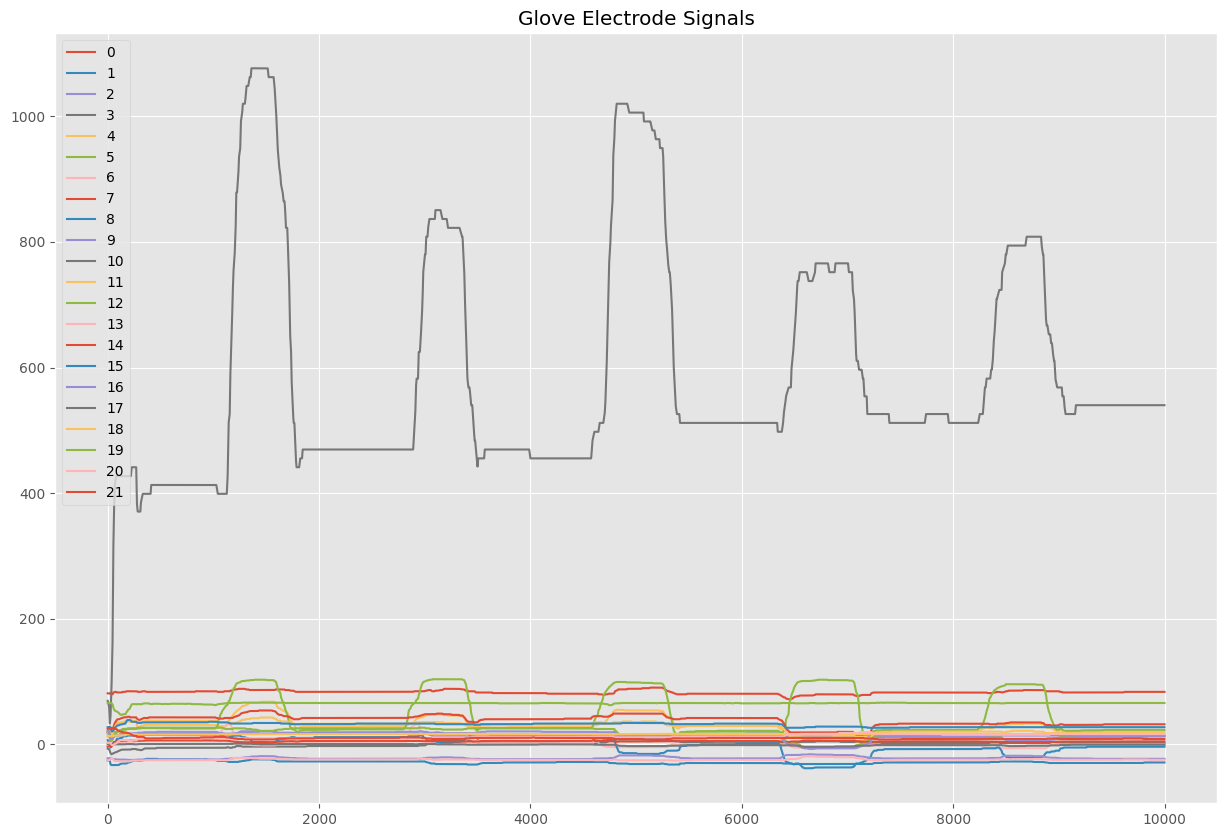

In [11]:
data_glove[:10000].plot(figsize=(15,10), title="Glove Electrode Signals")

In [12]:
print(f"Exercise number {mat['exercise'].item()}")
print(f"{mat['frequency'].item()} Hz")
print(mat['emg'].shape)
print(mat['glove'].shape)

Exercise number 3
200 Hz
(130267, 16)
(130267, 22)


In [13]:
level = 4
signature = iisignature.sig(mat['glove'], 2)

In [14]:
assert signature.shape[0] == 22 * 22 + 22